# Catan Board Generation

## Todo
- [x] Move to notebooks
- [x] Create git repo
- [x] Install git notebook extensions https://coderefinery.github.io/jupyter/version-control/
- [x] Play around with SVG library to see if it would be better https://pypi.org/project/drawSvg/
- [x] Convert point class to a collections.namedtuple https://docs.python.org/3.8/library/collections.html#collections.namedtuple
- [x] Tidy code
- [x] Refactor code so that it uses a hexagonal co-ordinate system https://www.redblobgames.com/grids/hexagons/#hex-to-pixel
- [x] Make display_board modular
- [x] Add dots to tokens
- [x] Fix issues when changing hex sizes
- [x] Use ordered elements append to create layers 
- [x] Figure out vertices
- [x] Add empty outer layer
- [x] Draw ports (4 x 3:1 + 5 x 2:1)
- [x] Add ports to board logic
- [x] Tidy up new code
- [x] Comment new functions
- [ ] Figure out how to make colour blind friendly
- [ ] Think about metrics
- [ ] Calculate number of possible boards

## Code

In [45]:
from math import sqrt, sin, cos, pi, isclose
from __future__ import annotations
import os
from random import randint, shuffle, seed
from dataclasses import dataclass, field
import drawSvg as draw

seed(2022)

In [144]:
@dataclass
class Point:
    """Implements two dimensional points.
    
    Attributes:
        x: A float denoting the point's coordinate along the x axis.
        y: A float denoting the point's coordinate along the y axis.
    """
    
    x: float
    y: float
    
@dataclass
class Hex:
    """Implements a discrete hexagonal co-ordinate system.
    
    Three axes, q, r and s are used. Each location in the system satisfies 
    the constraint q + r + s = 0, so we don't need to request all three as
    input, as the third can be calculated (e.g. s = -q - r). 
    
    See www.redblobgames.com/grids/hexagons/ for more details on hexagonal
    co-ordinate systems.
    
    Attributes:
        q: An int denoting the hexagon's coordinate along the q axis.
        r: An int denoting the hexagon's coordinate along the r axis.
        s: An int denoting the hexagon's coordinate along the s axis.
    """
    
    q: int
    r: int
    s: int = field(init=False)
    
    def __post_init__(self):
        self.s = -self.q - self.r

    def __eq__(self, other):
        return self.q == other.q and self.r == other.r
    
    def __hash__(self):
        return hash((self.q, self.r))
    

@dataclass
class Board:
    """Implements a board data structure.
    
    Board objects are used to store 
    
    Attributes:
        hexes: A set of hexes that make up the board.
        hex_types: A dict containing the types of each hex.
        hex_tokens: A dict containing the token on each hex.
        harbors: A set containing the locations of each harbor.
        harbor_types: A dict containing the type of each harbor.
        hex_harbors: A dict containing the harbors, using the hexes as keys.
    """
    
    hexes: set[Hex] = field(default_factory=set)
    hex_types: dict[Hex, str] = field(default_factory=dict)
    hex_tokens: dict[Hex, int] = field(default_factory=dict)
    harbors: set[tuple[tuple[Hex]]] = field(default_factory=set)
    harbor_types: dict[tuple[tuple[Hex]], str] = field(default_factory=dict)
    hex_harbors: dict[Hex, list[str]] = field(default_factory=dict)

## Functions used to generate a symbolic representation of the board

In [146]:
def init_board(board: Board = Board(), radius: int = 2) -> Board:
    """Initialises a hexagonal board.
    
    Creates a hexagonal board with a given radius. A radius of r means that the 
    minimum and maximum value for each axis is -r and r respectively.  
    
    Args:
        radius: A float, the desired radius of the board.
            
    Returns:
        A Board object, with hexes stored in the hexes attribute.    
    """
    
    board = Board()
    board.radius = radius
    # radius += 1  # Need a surrounding ring of 'null' hexes for vertex id
    for q in range(-radius, radius + 1):
        r1 = max(-radius, -q - radius)
        r2 = min(radius, -q + radius)
        for r in range(r1, r2 + 1):
            board.hexes.add(Hex(q,r))

    return board


def assign_hex_types(board: Board, hex_types: list[str]) -> None:
    """Assigns types to the board hexes.
    
    Each hex on the board is assigned one of a select number of types,
    representing the type of resource produced by that hex.
    
    Args:
        board: A Board object containing the hexes to assign types to.
        hex_types: A list of strings, containing the types available to assign,
            with each type repeated as many times as it can be assigned to 
            distinct hexes. For example, if we wanted to assign the 'grain'
            type to three different hexes on our board, the string 'grain'
            would appear three times in hex_types.  
    """
    
    hex_types = hex_types.copy()
    shuffle(hex_types)
    for hex_ in board.hexes:
        board.hex_types[hex_] = hex_types.pop()


def assign_hex_tokens(board: Board, tokens: list[str]) -> None:
    """Assigns tokens to the board hexes.
    
    Each hex on the board is assigned one token, with value between 2 and 12.
    The hex generates resources of its type when its token value is rolled.
    
    Args:
        board: A Board object containing the hexes to assign tokens to.
        hex_tokens: A list of ints, containing the token values available to
        assign, with each value repeated as many times as it can be assigned
        to distinct hexes. 
    """
        
    tokens = tokens.copy()
    shuffle(tokens)
    for hex_ in board.hexes:
        if board.hex_types[hex_] != 'desert':
            token = tokens.pop()
        else:
            token = None
        board.hex_tokens[hex_] = token

        
def assign_harbors(board: Board, 
                harbor_locations: list[list[tuple[Hex]]],
                harbor_types: list[str]) -> None:
    """Assigns harbors around the board.
    
    Harbors can be placed around the edge of the board, allowing players to
    more efficiently trade in resources.
    
    Args:
        board: A Board object containing the hexes to assign types to.
        harbor_locations: A list of vertex pairs (where each vertex is a 
            triple of hexes), denoting the locations to place the harbors.
        harbor_types: A list of strings, containing the harbor types available
            to assign, with each type repeated as many times as it can be 
            assigned to distinct hexes.
    """
    
    harbor_types = harbor_types.copy()
    shuffle(harbor_types)
    for vertex_pair in harbor_locations:
        board.harbors.add(vertex_pair)
        harbor_type = harbor_types.pop()
        board.harbor_types[vertex_pair] = harbor_type
        for vertex in vertex_pair:
            for hex_ in vertex:
                if hex_ in board.hexes:
                    try:
                        board.hex_harbors[hex_].add(harbor_type)
                    except KeyError:
                        board.hex_harbors[hex_] = set([harbor_type])
                                    
        
def create_random_board(radius: int, 
                        hex_types: list[str], 
                        tokens: list[int],
                        harbor_locations: list[list[tuple[Hex]]],
                        harbor_types: list[str]) -> Board:
    """Creates a randomly initialised board.
    
    Convenient wrapper for calling the functions required to generate a
    complete board.
    
    Args:
        radius: An int, as described in init_board().
        hex_types: A list of strings, as described in assign_hex_types().
        tokens: A list of ints, as described in assign_hex_tokens().
        harbor_locations:  A list of vertex pairs, as described in
            assign_harbors().
        harbor_types: A list of strings, as described in assign_harbors().
        
    Returns:
        board: A dict, as described in init_board().
    """
    
    board = init_board(radius = radius)
    assign_hex_types(board, types)
    assign_hex_tokens(board, tokens)
    assign_harbors(board, harbor_locations, harbor_types)
    return board

## Functions used to create a visual representation of the board

In [4]:
def rotate(point: Point, angle: float, origin: Point=Point(0, 0)) -> Point:
    """Rotates a two dimensional point by a given angle about another point.
    
    Args:
        point: A Point, the point to rotate.
        angle: A float, the angle, in radians, to rotate point by.
        origin: A Point, the point by which to center the rotation around.
        
    Return:
        p_r: A Point, the image of point under the specified rotation.
    """
    
    p = point
    o = origin
    a = angle
    del_x = p.x - o.x
    del_y = p.y - o.y
    x = o.x + del_x * cos(a) - del_y * sin(a)
    y = o.y + del_x * sin(a) + del_y * cos(a)
    p_r = Point(x, y)
    return p_r


def hex_to_center_pixel(hex_: Hex, size: float) -> Point:
    """Converts hex coords to a single xy coord denoting the hex's center.
    
    To render the hexes on a screen, conversion between hex co-ordinates and two 
    dimensional cartesian coordinates is required. This function converts the
    coords of the given hex to a single 2D point, which denotes the location
    of the center of the hex in the cartesian coordinate system. 
    
    Args:
        hex_: A Hex, the hex to calculate the center coord of.
        size: A float, the length, in pixels, of the sides hex rendering.
        
    Return:
        center: A Point, the center of the hex to be rendered.
    """
    
    x = size * (sqrt(3) * hex_.q + sqrt(3)/2 * hex_.r)
    y = size * (3/2 * hex_.r)
    center = Point(x,y)
    return center


def hex_to_vertex_pixels(hex_: Hex, size: float) -> list[Point]:
    """Converts hex coords to six xy coords denoting the hex's vertices.
    
    Similar to hex_to_center_pixel(), but calculates coords of the vertices
    instead of the coords of the center.
    
    Args:
        hex_: A Hex, the hex to calculate the vertex coords of.
        size: A float, the length, in pixels, of the sides hex rendering.
        
    Return:
        points: A list of six Points, denoting the coords of the hex vertices.  
    """
    
    center = hex_to_center_pixel(hex_, size)
    p1 = Point(center.x, center.y + size)
    angles = [pi/3 * x for x in range(6)]
    points = [rotate(p1, angle, center) for angle in angles]
    return points

def hex_intersection_to_vertex_pixel(h1: Hex, h2: Hex, h3: Hex) -> Point:
    """Converts 3 hex coords to a single xy coord denoting their shared vertex.
    
    Vertices in a hex coord system are shared between three hexes. This
    calculates the cartesian coordinate of the vertex that is uniquely
    identified by these three vertices. 
    
    Args:
        h1: A Hex that contains the vertex.
        h2: A Hex that contains the vertex.
        h3: A Hex that contains the vertex.
        
    Return:
        vertex: A Point with coordinates of the shared vertex.  
    """
    
    c1 = hex_to_center_pixel(h1, 50)
    c2 = hex_to_center_pixel(h2, 50)
    c3 = hex_to_center_pixel(h3, 50)
    vertex = Point((c1.x + c2.x + c3.x)/3, (c1.y + c2.y + c3.y)/3)
    return vertex

def points_to_coordinate_list(points: list) -> list[float]: 
    """Concatenates co-ordinates of a list of points into a list of floats.
    
    For example, the list [Point(x=1, y=2), Point(x=3, y=4)] would be flattened
    to a list of floats, [1, 2, 3, 4]. 
    
    This format is required for compatibility with the drawSvg functions.
    
    Args:
        vertices: A list of Points.
        
    Return:
        points: A list of floats, flattended coords of the points.
    """
    
    coordinates = []
    for point in points:
        coordinates.append(point.x)
        coordinates.append(point.y)
    return coordinates

In [180]:
def roll_freq(value: int):
    """ Returns the relative frequency of a value being rolled by two dice.
    
    Returns the number of ways a value, between 2 and 12 inclusive, can be
    rolled by two, standard six sided die.
    
    Args:
        value: An int between 2 and 12.
    
    Return:
        rel_freq: An int, the number of different ways to roll value.
    """
    assert value >= 2 and value <= 12
    rel_freq = 6 - abs(7 - value)
    return rel_freq


def init_canvas(width, height):
    """ Initialise the SVG canvas on which to draw the board.
    """
    d = draw.Drawing(width, height, origin='center')
    return d


def draw_background(d):
    """ Draw the background/water hex.
    """
    vertex_coords = hex_to_vertex_pixels(Hex(0,0), hex_size * 5.8)
    for i in range(len(vertex_coords)):
        vertex_coords[i] = rotate(vertex_coords[i], pi/6)
    vertex_coords = points_to_coordinate_list(vertex_coords)
    d.append(draw.Lines(*vertex_coords,close=True,
                            fill=hex_colours['water'],
                            stroke=stroke_colour, stroke_width=stroke_width),
            z=0)
    
    
def draw_board_outline(d, board):
    """ Draw a plain outline of the board.
    """
    for hex_ in board.hexes:
        vertex_coords = points_to_coordinate_list(
            hex_to_vertex_pixels(hex_, hex_size))
        coords = (hex_.q, hex_.r)
        d.append(draw.Lines(*vertex_coords,
                            close=True,
                            fill='#FFFFFF',
                            stroke=stroke_colour, 
                            stroke_width=stroke_width,
                            coords = coords
                           ),
                z=1)

        
def fill_board(d, board):
    """ Fill the board hexes with their type colours.
    """
    for element in d.allElements():
        try:
            coords = element.args['coords']
            fill_colour = hex_colours[board.hex_types[Hex(*coords)]]
            element.args['fill'] = fill_colour
        except KeyError: pass

        
        
def draw_tokens(d, board, show_dots=True):
    """ Draw each hexes token on the baod.
    """
    for hex_ in board.hexes:
        center = hex_to_center_pixel(hex_, hex_size)
        hex_token = board.hex_tokens[hex_]
        if hex_token is not None:
            if hex_token == 6 or hex_token == 8:
                token_colour = token_text_colour[0]
            else:
                token_colour = token_text_colour[1]
            font_size = 31 - 2.5 * abs(7 - hex_token)
            # font_size = 29

            d.append(draw.Circle(center.x, center.y, 
                                 r=radius, fill=token_fill_colour), 
                     z=2)

            if show_dots: 
                vert_off = 3 
            else: 
                vert_off = 0

            d.append(draw.Text(str(hex_token), fontSize=font_size, 
                               x=center.x, y=center.y + vert_off, center=True, 
                               valign = 'middle', font_family = font_family, 
                               fill = token_colour, font_weight = 'bold'),
                     z=3)

            if show_dots:
                r = 1.6
                num_dots = roll_freq(hex_token)
                dots = []
                if num_dots % 2 == 0:
                    for i in range(1, num_dots // 2 + 1):
                        x_del = 3*r/2 + (i - 1) * 3 * r
                        dots.append(Point(center.x + x_del, center.y - 15))
                        dots.append(Point(center.x - x_del, center.y - 15))

                else:
                    for i in range(0, num_dots // 2 + 1):
                        x_del = 3 * r * i
                        dots.append(Point(center.x + x_del, center.y - 15))
                        if x_del != 0:
                            dots.append(Point(center.x - x_del, center.y - 15))

                for dot in dots:
                    d.append(draw.Circle(dot.x, dot.y, r, 
                                         fill = token_colour), z=3)
        

def draw_coords(d, board):
    """Display the coords of each hex on the board. 
    """
    for hex_ in board.hexes:
        coords = (hex_.q, hex_.r, hex_.s)
        center = hex_to_center_pixel(hex_, hex_size)
        d.append(draw.Text(str(coords), fontSize=18, 
                   x=center.x, y=center.y, center=True, 
                   valign = 'middle', font_family = "Open Sans", 
                   fill = 'black'), 
                 z=2)

def draw_harbors(d, board, simple=False):
    """Draw the harbors onto the board.
    """
    for vertex_pair in board.harbors:
        p1 = hex_intersection_to_vertex_pixel(*vertex_pair[0])
        p2 = hex_intersection_to_vertex_pixel(*vertex_pair[1])
        p3 = rotate(p1, pi/3, p2)
        harbor_type = board.harbor_types[vertex_pair]
        fill = harbor_colours[harbor_type]
        ratio = 3 if harbor_type == 'generic' else 2
        if not simple:
            harbor_fill = token_fill
            d.append(draw.Text(f'{ratio}:1',
                               fill=fill, 
                               fontSize=12, 
                               font_family=font_family,
                               font_weight='bold', 
                               x=p3.x, y=p3.y, center=True, valign = 'middle'), 
                     z = 4)
        else:
            harbor_fill = fill
        
        d.append(draw.Circle(p3.x, p3.y, r=13, 
                     fill=harbor_fill, fill_opacity=1, 
                     stroke=fill, stroke_width=4), z=3)
        d.append(draw.Line(p1.x, p1.y, p3.x, p3.y, 
                           stroke = 'black', stroke_width=3,
                           stroke_opacity = 0.5), z=1)
        d.append(draw.Line(p2.x, p2.y, p3.x, p3.y, 
                           stroke ='black', stroke_width=3, 
                           stroke_opacity = 0.5), z=1)

        
def draw_complete_board(board, width, height, simple=False):
    """Draw the board, wrapper function.
    """
    show_dots = False if simple else True
    d = init_canvas(width, height)
    draw_background(d)
    draw_board_outline(d, board)
    fill_board(d, board)
    draw_tokens(d, board, show_dots=show_dots)
    draw_harbors(d, board, simple=simple)
    return d
    

## Creating the board

In [161]:
hex_types = (4 * ['wool'] + 
         4 * ['grain'] + 
         4 * ['lumber'] + 
         3 * ['ore'] + 
         3 * ['brick'] + 
         1 * ['desert'])

tokens = (1 * [2] + 
          2 * [3] + 
          2 * [4] + 
          2 * [5] + 
          2 * [6] + 
          2 * [8] + 
          2 * [9] + 
          2 * [10] + 
          2 * [11] + 
          1 * [12])

harbor_locations = [  # Vertices are defined by hex triples
    ((Hex(0,2), Hex(-1, 2), Hex(-1,3)), (Hex(-1,2), Hex(-1,3), Hex(-2,3))),
    ((Hex(-2,2), Hex(-2,3), Hex(-3,3)), (Hex(-2,2), Hex(-3,3), Hex(-3,2))),
    ((Hex(-2,1), Hex(-3,2), Hex(-3,1)), (Hex(-2,1), Hex(-2,0), Hex(-3,1))),
    ((Hex(-2,0), Hex(-1,-1), Hex(-2,-1)), 
     (Hex(-1,-2), Hex(-1,-1), Hex(-2,-1))),
    ((Hex(0,-2), Hex(-1,-2), Hex(0,-3)), (Hex(0,-2), Hex(0,-3), Hex(1,-3))),
    ((Hex(1,-2), Hex(1,-3), Hex(2,-3)), (Hex(1,-2), Hex(2,-3), Hex(2,-2))),
    ((Hex(2,-1), Hex(2,-2), Hex(3,-2)), (Hex(2,-1), Hex(3,-2), Hex(3,-1))),
    ((Hex(2,0), Hex(3,0), Hex(3,-1)), (Hex(2,0), Hex(3,0), Hex(2,1))),
    ((Hex(1,1), Hex(1,2), Hex(2,1)), (Hex(1,1), Hex(1,2), Hex(0,2)))
]

harbor_types = (1 * ['wool'] + 
                1 * ['grain'] + 
                1 * ['lumber'] + 
                1 * ['ore'] +
                1 * ['brick'] + 
                4 * ['generic'])

In [162]:
board = create_random_board(2, hex_types, tokens, 
                            harbor_locations, harbor_types)

# Visualising the board

In [175]:
width = 600
height = width
hex_size = 50
hex_colours = {
    'wool': '#a7c957',
    'grain': '#DFB853',
    'lumber': '#20703D',
    'ore': '#969696',
    'brick': '#C37C3A',
    'desert': '#DCBB96',
    'water': '#B9E3F3'
}
token_fill_colour = "#FFEDD0"
token_text_colour = ("#BD0000", "#100C08")
harbor_colours = { # Darker shades of hex_colours
    'wool': '#93B93C',
    'grain': '#D9A82E',
    'lumber': '#1B5F34',
    'ore': '#969696',
    'brick': '#A86B32',
    'generic': '#2A1B0D'
}
font_family = "Open Sans"
stroke_colour = "#100C08"
stroke_width = 3

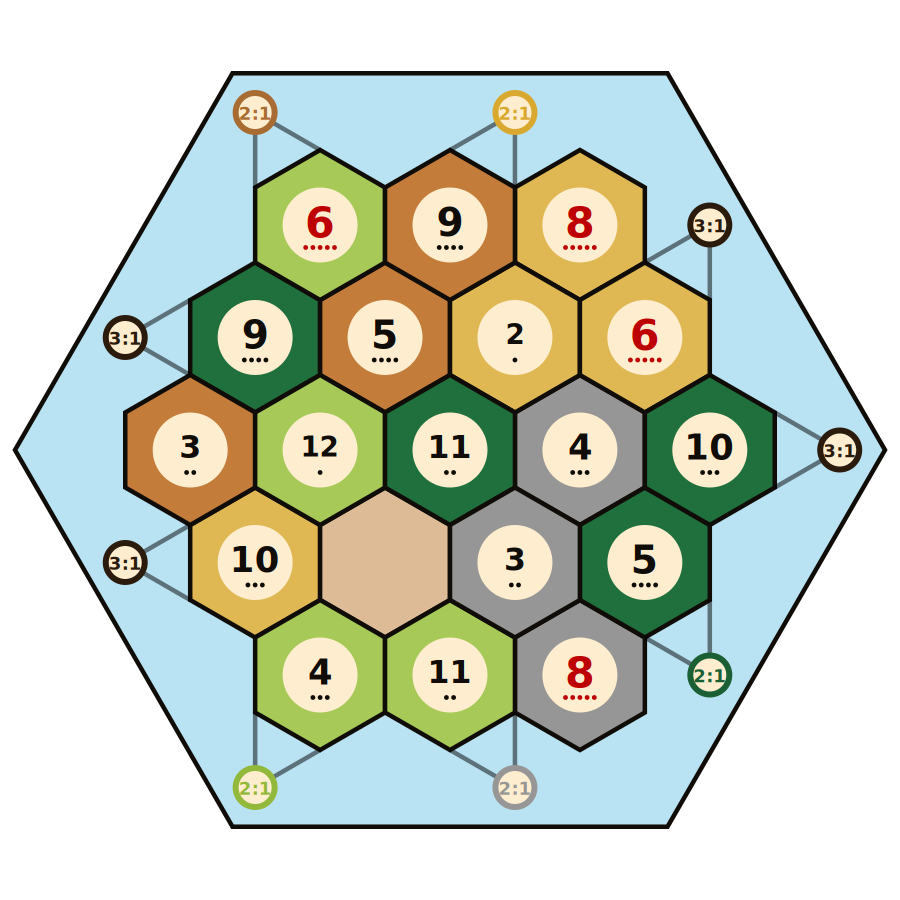

In [186]:
d = draw_complete_board(board, width, height)
d.setPixelScale(1.5)
# draw_coords(d, board)
# d.saveSvg('board.svg')
# d.savePng('board.png')
d

In [ ]:
d = init_canvas(width, height)
draw_background(d, hex_size)
draw_board_outline(d, board, hex_size)
fill_board(d, board)
draw_coords(d, board)
d.setPixelScale(1.5) 
d

## Metrics
- Token distribution:
    1. How evenly spread the tokens/values are on the board (sum of token values at each vertex)
    2. How evenly spread the tokens/values are across different resources (~~average token value per resource type~~, roll_freqability of recieving a resource on a given roll)
- Resource distribution:
    1. How evenly spread the terrains are across the board (Average distance to neighbours for each type)

## Token distribution across hex types

In [192]:
from statistics import variance as var

min_var = 100
min_dist = None 
min_board = None

def roll_freq(roll: int):
    return 6 - abs(7 - roll)


for i in range(10000):
    board = create_random_board(2, hex_types, tokens, 
                                harbor_locations, harbor_types)
    dist = {'wool': 0, 'grain': 0, 'lumber': 0, 'ore': 0, 'brick': 0}    

    for hex_ in board.hexes:
        hex_type = board.hex_types[hex_]
        if hex_type != 'desert':
            dist[hex_type] += roll_freq(board.hex_tokens[hex_])

    for key, val in dist.items():
        if key in ['wood', 'grain', 'lumber']:
            dist[key] = dist[key] / 4
        else:
            dist[key] = dist[key] / 3
    
    v = var(dist.values())
    if v < min_var:
        min_var = v
        min_dist = dist
        min_board = board

0.00833333333333332
{'wool': 3.3333333333333335, 'grain': 3.5, 'lumber': 3.5, 'ore': 3.3333333333333335, 'brick': 3.3333333333333335}


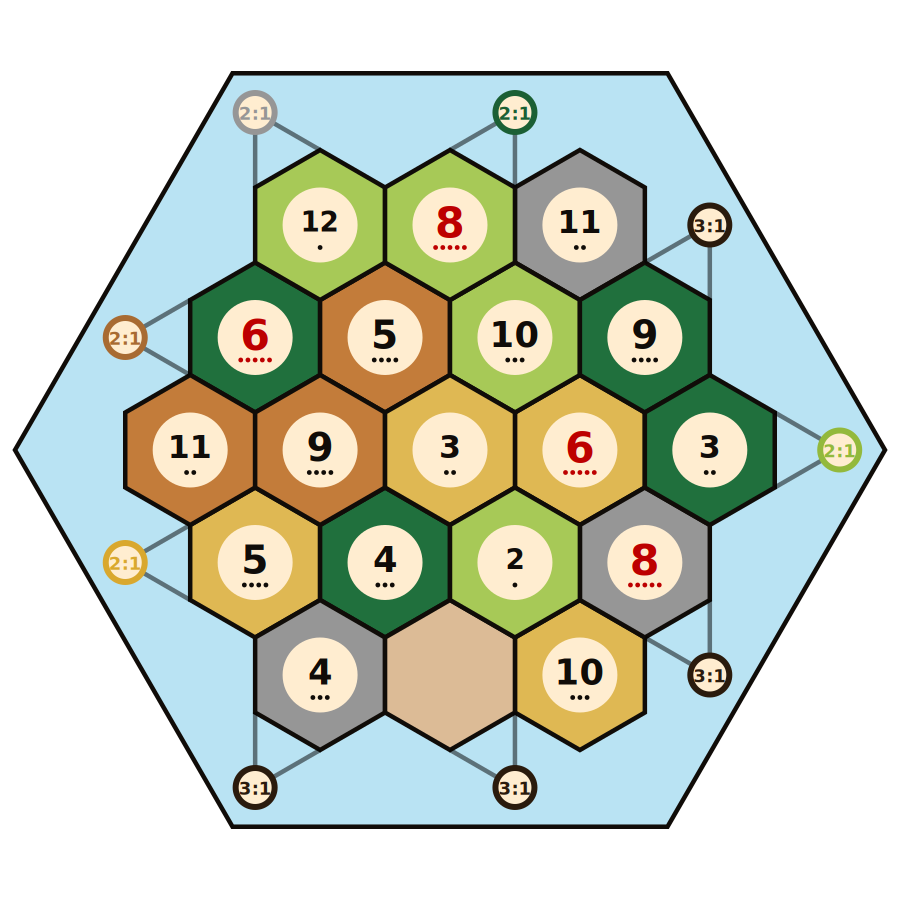

In [193]:
print(min_var)
print(min_dist)
d = draw_complete_board(min_board, width, height)
d.setPixelScale(1.5)
d

## Token distribution across location
Each vertex should have roughly the same chance (weighted by number of neighbours) of being rolled each turn.

## Token diversity/clustering
Neighbouring tokens should not share the same values.